## Multi-View Fuzzy Clustering

Lendo os dados. Cada conjunto aqui sera uma view que sera utilizada para construir uma matriz de dissimilaridade
Euclidiana. No total, serao 3 matrizes de dissimilaridade, todas com a mesma métrica (distância Euclidiana) mas
uma para cada view.

In [1]:
import math
import numpy as np
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
dfac = pd.read_csv('dados/mfeat-fac', delim_whitespace=True, header=None)
dfou = pd.read_csv('dados/mfeat-fou', delim_whitespace=True, header=None)
dkar = pd.read_csv('dados/mfeat-kar', delim_whitespace=True, header=None)

Calculando as matrizes de dissimilaridade para cada view.

In [3]:
from sklearn.metrics.pairwise import euclidean_distances

dfac_matrix = euclidean_distances(dfac, dfac)
dfou_matrix = euclidean_distances(dfou, dfou)
dkar_matrix = euclidean_distances(dkar, dkar)
dist_matrixes = np.asarray([dfac_matrix, dfou_matrix, dkar_matrix])

Segundo a documentaçao do scikit-learn, em algumas situacoes, por questoes de precisao, a matriz pode nao ser
exatamente simetrica. Portanto, estou checando se cada matriz gerada e simetrica dentro de uma tolerancia de erro
de 1e-8.

In [4]:
import numpy as np

print(np.allclose(dfac_matrix, dfac_matrix.T, atol=1e-8))
print(np.allclose(dfou_matrix, dfou_matrix.T, atol=1e-8))
print(np.allclose(dkar_matrix, dkar_matrix.T, atol=1e-8))

True
True
True


As matrizes geradas sao simetricas.

Inicializando agora os parametros do algoritmo.

In [5]:
# PARAMETROS
# Numero de clusters
K = 10
# Parametro m
m = 1.6
# Parametro s
s = 1
# Parametro q
q = 3
# Numero maximo de iteracoes
T = 100
# Flutuacao minima para parada (criterio de parada)
E = 1

Implementando a funcao para calcular o grau de pertinencia de um elemento i (element_index) para o cluster k
(cluster_index).

In [6]:
def membership_degree(element_index, cluster_index, lambdas, prototypes, dist_matrixes, s, m):
    final_sum = 0
    
    numerator = 0
    for j, lambda_v in enumerate(lambdas):
        distances_sum = 0
        distance_matrix = dist_matrixes[j]
        for prot_element_index in prototypes[cluster_index]:
            distances_sum += distance_matrix[element_index][prot_element_index]
        numerator += pow(lambda_v, s) * distances_sum
    
    for h, prototype in enumerate(prototypes):        
        denominator = 0
        for j, lambda_v in enumerate(lambdas):
            distances_sum = 0
            distance_matrix = dist_matrixes[j]
            for prot_element_index in prototype:
                distances_sum += distance_matrix[element_index][prot_element_index]
            denominator += pow(lambda_v, s) * distances_sum
        final_sum += pow(numerator / denominator, 1.0 / (m - 1))
    
    return pow(final_sum, -1)

Implementando funçao que atualiza os graus de pertinencia de cada elemento para cada cluster fuzzy.

In [7]:
def update_membership_degrees(lambdas, prototypes, dist_matrixes, s, m):
    membership_degrees = []
    for i in range(0, len(dist_matrixes[0])):
        new_line = []
        for k in range(0, len(prototypes)):
            new_line.append(membership_degree(i, k, lambdas, prototypes, dist_matrixes, s, m))
        new_line = np.asarray(new_line)
        membership_degrees.append(new_line)
    return np.asarray(membership_degrees)

Implementando funcao que calcula a adequaçao do agrupamento (funcao objetivo que e minimizada).

In [8]:
def calculate_adequacy_criterion(membership_degrees, lambdas, prototypes, dist_matrixes, s, m):
    final_sum = 0
    for k, prototype in enumerate(prototypes):
        sum2 = 0
        for i, membership_degree in enumerate(membership_degrees):
            sum1 = 0
            for j, lambda_v in enumerate(lambdas):
                distances_sum = 0
                distance_matrix = dist_matrixes[j]
                for prot_element_index in prototype:
                    distances_sum += distance_matrix[i][prot_element_index]
                sum1 += pow(lambda_v, s) * distances_sum
            sum2 += pow(membership_degree[k], m) * sum1
        final_sum += sum2
    return final_sum

A partir daqui, 3 passos serao intercalados ate o criterio de parada ser atingido: Definicao dos melhores
prototipos, calculo dos pesos das matrizes de dissimilaridade e calculo da matriz dos graus de pertinencia. A
ultima funcao ja esta implementada, restando a implementacao das duas primeiras.

Implementando funcao de definicao dos melhores prototipos.

In [9]:
def define_prototypes(membership_degrees_matrix, lambdas, dist_matrixes, s, m):
    prototypes = []
    for k in range(0, K):
        new_prototype = []
        for q_counter in range(0, q):
            min_value = float("inf")
            min_index = -1
            for h in range(0, len(membership_degrees_matrix)):
                total_sum = 0
                for i in range(0, len(membership_degrees_matrix)):
                    distances_sum = 0
                    for j, lambda_v in enumerate(lambdas):
                        distances_sum += pow(lambda_v, s) * dist_matrixes[j][i][h]
                    total_sum += pow(membership_degrees_matrix[i][k], m) * distances_sum
                if total_sum < min_value and h not in new_prototype:
                    min_value = total_sum
                    min_index = h
            new_prototype.append(min_index)
        new_prototype = np.asarray(new_prototype)
        prototypes.append(new_prototype)
    return np.asarray(prototypes)

Implementando funcao de update dos lambdas.

In [10]:
def calculate_lambda(matrix_index, membership_degrees_matrix, prototypes, dist_matrixes, s, m):
    denominator = 0
    for k in range(0, K):
        sum1 = 0
        for i in range(0, len(membership_degrees_matrix)):
            distances_sum = 0
            distance_matrix = dist_matrixes[matrix_index]
            for prot_element_index in prototypes[k]:
                distances_sum += distance_matrix[i][prot_element_index]
            sum1 += pow(membership_degrees_matrix[i][matrix_index], m) * distances_sum
        denominator += sum1
    
    produtorio = 1    
    for h in range(0, len(dist_matrixes)):
        sum_ = 0
        for k in range(0, K):
            for i in range(0, len(membership_degrees_matrix)):
                distances_sum = 0
                distance_matrix = dist_matrixes[h]
                for prot_element_index in prototypes[k]:
                    distances_sum += distance_matrix[i][prot_element_index]
                sum_ += pow(membership_degrees_matrix[i][matrix_index], m) * distances_sum
        produtorio *= pow(sum_, 1.0 / len(dist_matrixes))
    
    return produtorio / denominator

In [11]:
def update_lambdas(membership_degrees, prototypes, dist_matrixes, s, m):
    new_lambdas = []
    for j in range(0, len(dist_matrixes)):
        new_lambdas.append(calculate_lambda(j, membership_degrees, prototypes, dist_matrixes, s, m))
    return np.asarray(new_lambdas)

Colocaremos agora as operacoes executando de maneira intercalada dentro de iteracoes. De acordo com o solicitado
no projeto, devemos executar 100 vezes e pegar o melhor resultado.

In [12]:
def run(executions, run_id):
    J_values_over_time = []
    lambdas_over_time = []
    membership_degrees_matrix_over_time = []
    for i in range(0, executions):
        J_values_over_time.append([])
        lambdas_over_time.append([])
        membership_degrees_matrix_over_time.append([])
        # Inicializando prototipos aleatoriamente
        # Prototipos sao representados por indices (numero da linha nas matrizes de dissimilaridade)
        prototypes = []
        for j in range(0, K):
            prototypes.append(np.random.randint(len(dfac_matrix), size=q))
        prototypes = np.asarray(prototypes)
        # Peso de relevancia para cada view
        lambdas = np.asarray([1.0] * len(dist_matrixes))
        membership_degrees_matrix = update_membership_degrees(lambdas, prototypes, dist_matrixes, s, m)
        t = 0
        J = calculate_adequacy_criterion(membership_degrees_matrix, lambdas, prototypes, dist_matrixes, s, m)
        J_anterior = J
        delta_J = J
        while abs(delta_J) >= E and t < T:
            print('Execution: ' + str(i) + ' - Iteration: ' + str(t))
            prototypes = define_prototypes(membership_degrees_matrix, lambdas, dist_matrixes, s, m)
            lambdas = update_lambdas(membership_degrees_matrix, prototypes, dist_matrixes, s, m)
            membership_degrees_matrix = update_membership_degrees(lambdas, prototypes, dist_matrixes, s, m)
            J_anterior = J
            J = calculate_adequacy_criterion(membership_degrees_matrix, lambdas, prototypes, dist_matrixes, s, m)
            delta_J = J - J_anterior
            J_values_over_time[-1].append(J)
            lambdas_over_time[-1].append(lambdas)
            membership_degrees_matrix_over_time[-1].append(membership_degrees_matrix)
            t = t + 1
    file = open("J_values_over_time_" + str(run_id) + ".pck", 'wb') 
    pickle.dump(J_values_over_time, file)
    file.close()
    file = open("lambdas_over_time_" + str(run_id) + ".pck", 'wb') 
    pickle.dump(lambdas_over_time, file)
    file.close()
    file = open("membership_degrees_matrix_over_time_" + str(run_id) + ".pck", 'wb') 
    pickle.dump(membership_degrees_matrix_over_time, file)
    file.close()

Linha para execuçao da funçao anterior, recebendo o número de iteraçoes que deve executar e um id para diferenciar o arquivo que será salvo. Colocando esse script em um .py e rodando, o id do arquivo salvo pode ser pego através de sys.argv[1].

In [13]:
# run(5, sys.argv[1])
# Exemplo de uso:
# run(5, 1)

Dado o elevadíssimo tempo de execuçao, rodei tudo em scripts externos e gerei pickles com os resultados. Vamos agora abrir os pickles, concatenar tudo e encontrar o melhor resultado para extrair o que é pedido na especificaçao do projeto.

In [14]:
best_result_J = float("inf")
best_i = -1
best_j = -1
for i in range(1, 21):
    with (open("J_values_over_time_" + str(i) + ".pck", "rb")) as openfile:
        data = pickle.load(openfile)
        for j in range(0, len(data)):
            if data[j][-1] < best_result_J:
                best_result_J = data[j][-1]
                best_i = i
                best_j = j

In [15]:
openfile = open("lambdas_over_time_" + str(best_i) + ".pck", "rb")
best_lambda_values_over_time = pickle.load(openfile)
openfile = open("membership_degrees_matrix_over_time_" + str(best_i) + ".pck", "rb")
best_membership_degrees_matrix_over_time = pickle.load(openfile)

A seguir, pode-se encontrar heatmaps com graus de pertencimento aos clusters fuzzy para cada elemento e o cluster com maior valor do grau de pertencimento durante o processo da melhor execuçao. Infelizmente acabei nao capturando os dados antes da primeira iteraçao, apenas após suas execuçoes. Portanto, nao é possível visualizar as modificaçoes realizadas na primeira iteraçao, que é a iteraçao onde as modificaçoes sao mais severas. Em todas as outras, poucas coisas mudam, havendo apenas pequenos ajustes finos.

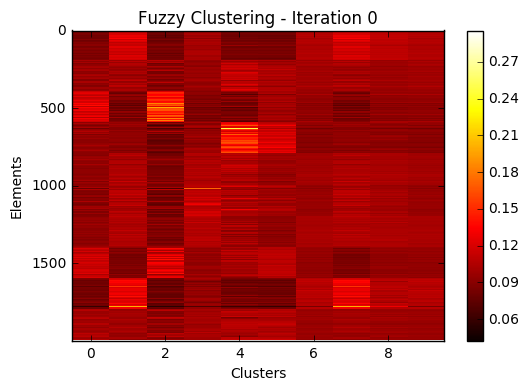

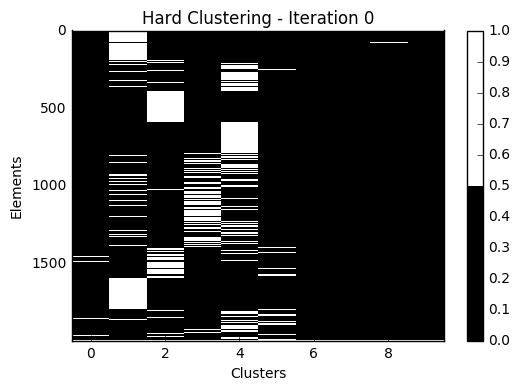

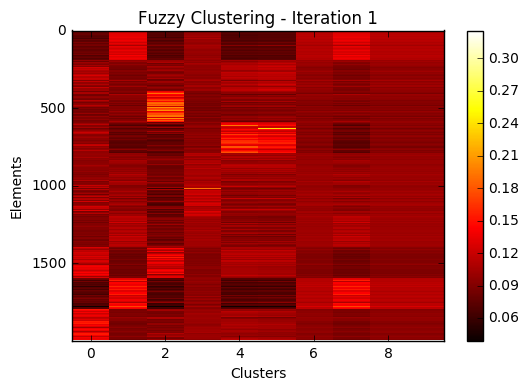

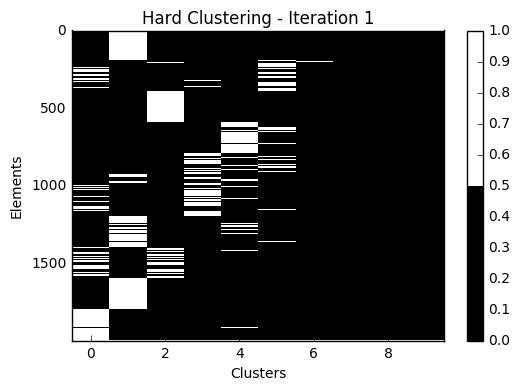

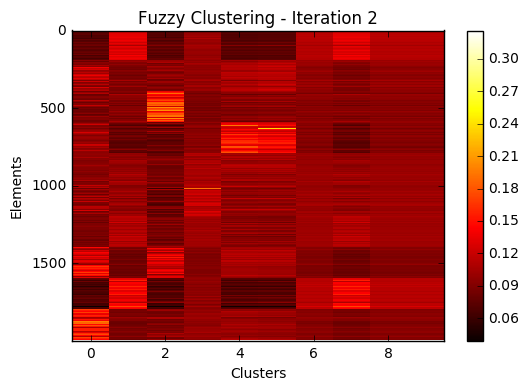

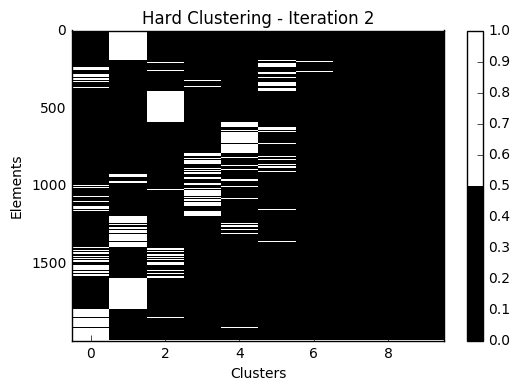

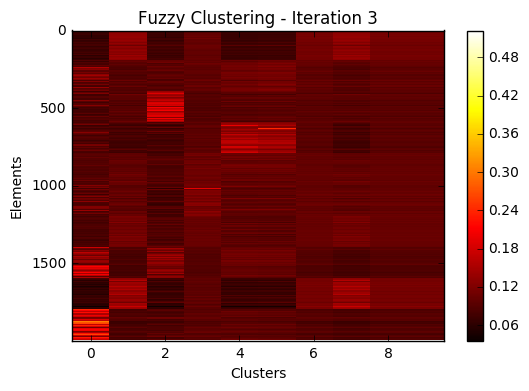

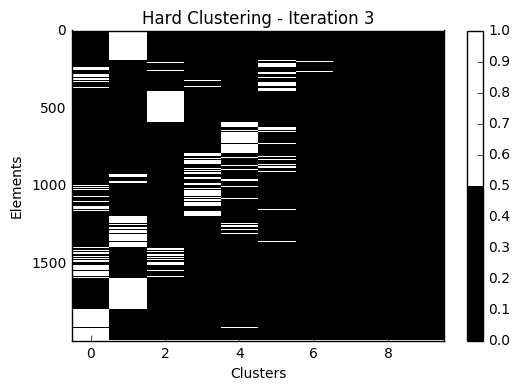

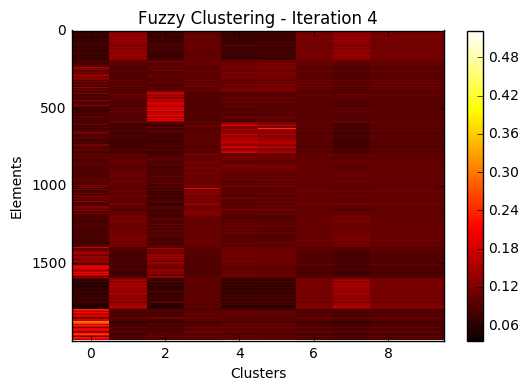

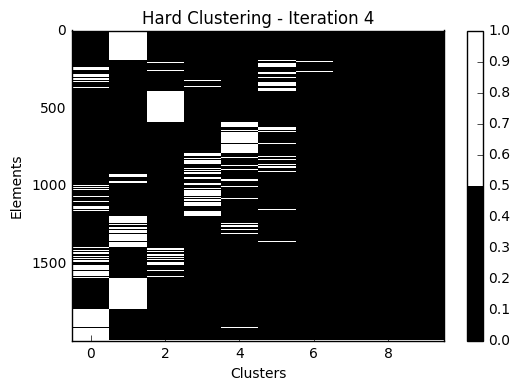

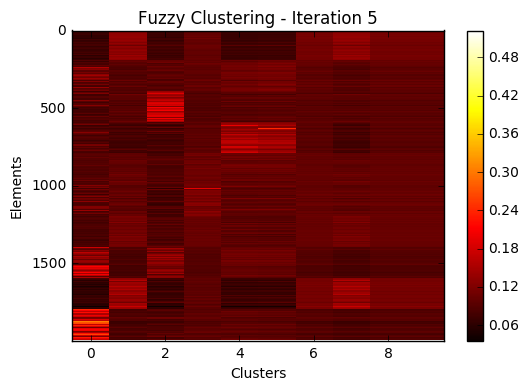

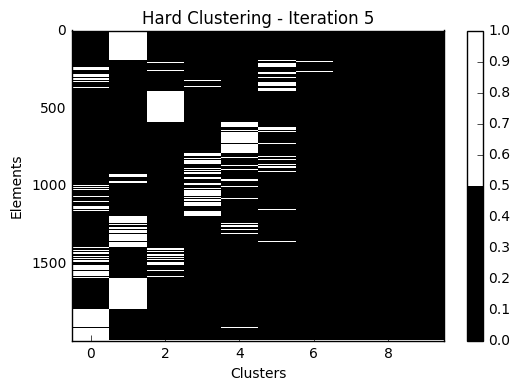

In [16]:
for i, membership_degrees_matrix in enumerate(best_membership_degrees_matrix_over_time[best_j]):
    plt.imshow(membership_degrees_matrix, cmap='hot', interpolation='nearest', aspect='auto',)
    plt.ylabel('Elements')
    plt.xlabel('Clusters')
    plt.title('Fuzzy Clustering - Iteration ' + str(i))
    plt.colorbar()
    plt.show()
    hard_clustering_matrix = np.zeros_like(membership_degrees_matrix)
    hard_clustering_matrix[np.arange(len(membership_degrees_matrix)), membership_degrees_matrix.argmax(1)] = 1
    plt.imshow(hard_clustering_matrix, cmap=mpl.colors.ListedColormap(['k', 'w']), interpolation='nearest', aspect='auto')
    plt.ylabel('Elements')
    plt.xlabel('Clusters')
    plt.title('Hard Clustering - Iteration ' + str(i))
    plt.colorbar()
    plt.show()

Nesse gráfico, pode-se ver a evoluçao (processo de minimizaçao) da adequaçao do agrupamento. Assim como dito anteriormente, as maiores mudanças sao vistas após a primeira iteraçao em comparaçao com o agrupamento antes de começar a execuçao do algoritmo. Infelizmente, acabei nao pegando essa informaçao antes da execuçao.

In [17]:
openfile = open("J_values_over_time_" + str(best_i) + ".pck", "rb")
best_J_values_over_time = pickle.load(openfile)
J_value_over_time = best_J_values_over_time[best_j]

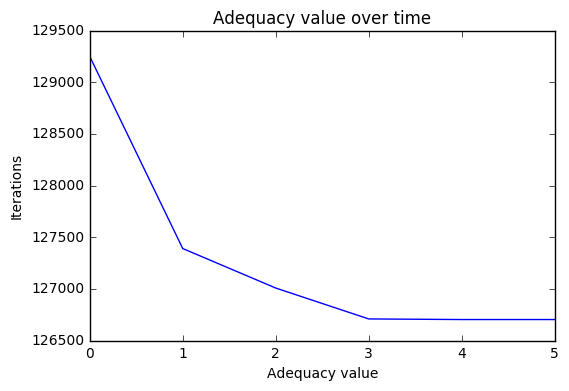

In [18]:
plt.plot(J_value_over_time)
plt.ylabel('Iterations')
plt.xlabel('Adequacy value')
plt.title('Adequacy value over time')
plt.show()

In [19]:
membership_degrees_matrix_final = best_membership_degrees_matrix_over_time[best_j][-1]
lambdas_final = best_lambda_values_over_time[best_j][-1]
prototypes = define_prototypes(membership_degrees_matrix_final, lambdas_final, dist_matrixes, s, m)

Índices dos elementos representantes de cada grupo.

In [20]:
for i, prototype in enumerate(prototypes):
    print("Grupo " + str(i) + ": " + str(prototype))

Grupo 0: [1891 1890 1986]
Grupo 1: [1689 1784 1677]
Grupo 2: [449 566 436]
Grupo 3: [ 692 1784 1025]
Grupo 4: [692 600 775]
Grupo 5: [692 600 639]
Grupo 6: [1689 1784  692]
Grupo 7: [1689 1784 1677]
Grupo 8: [1689 1784  692]
Grupo 9: [1689 1784  692]


Peso de cada view:

In [24]:
for i, lambda_value in enumerate(lambdas_final):
    print("Peso View " + str(i) + ": " + str(lambda_value))

Peso View 0: 0.0258123979249
Peso View 1: 35.0627553416
Peso View 2: 1.07065962015


Como solicitado no projeto, estou imprimindo aqui os membros de cada grupo através da partiçao exclusiva. Estou simplesmente pegando o maior grau de pertencimento e assumindo como indicador de qual grupo um dado elemento pertence. É o mesmo gráfico exibido como última iteraçao do algoritmo anteriormente. Branco significa que um dado elemento pertence a um dado grupo.

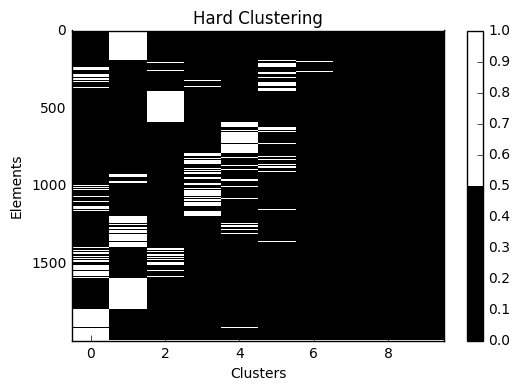

In [25]:
hard_clustering_matrix = np.zeros_like(membership_degrees_matrix_final)
hard_clustering_matrix[np.arange(len(membership_degrees_matrix_final)), membership_degrees_matrix_final.argmax(1)] = 1
plt.imshow(hard_clustering_matrix, cmap=mpl.colors.ListedColormap(['k', 'w']), interpolation='nearest', aspect='auto')
plt.ylabel('Elements')
plt.xlabel('Clusters')
plt.title('Hard Clustering')
plt.colorbar()
plt.show()

Calculando o índice de Rand ajustado do resultado.

In [26]:
adjusted_rand_score(membership_degrees_matrix_final.argmax(1), [int(i / 100) for i in range(100, 2100)])

0.22095677556822899